## 1. Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install timm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.7 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torchtext
import os
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision import transforms

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

## 2. Read dataset

In [4]:
file_path = '/content/drive/MyDrive/Colab Notebooks/vqa/data.csv'
data = pd.read_csv(file_path)

class_counts = data['answer'].value_counts()
class_counts_df = class_counts.reset_index()
class_counts_df.columns = ['Class', 'Count']

print(class_counts_df.head(35))

            Class  Count
0               2    554
1           table    421
2           chair    367
3               3    327
4          window    277
5           white    259
6           photo    252
7               1    252
8         picture    249
9         cabinet    245
10           lamp    237
11           sofa    227
12            bed    225
13              4    204
14          books    181
15           door    181
16    garbage_bin    167
17         mirror    155
18          brown    147
19         pillow    142
20            red    137
21          black    133
22     television    130
23          towel    124
24        clothes    117
25         blinds    114
26        curtain    111
27      bookshelf    102
28        shelves    101
29              5    100
30            bag     98
31           blue     97
32              6     96
33          paper     84
34  refridgerator     83


In [5]:
top_classes = class_counts.head(5).index.tolist()

# print(top_classes)

filtered_data = data[data['answer'].isin(top_classes)]

print(filtered_data)

                                                question answer   image_id
1      what is on the left side of the fire extinguis...  table     image1
2      what is between the the two white and black ga...  chair     image1
3      how many objects are between the fire extingui...      3     image1
19     what is in front of the papers and notebook an...  chair     image4
21     what is in front of the door and on the right ...  chair     image5
...                                                  ...    ...        ...
12460                     what is in front of the mantel  chair  image1448
12461                 what is to the right of the mantel  table  image1448
12463                 what is found below the chandelier  table  image1448
12465                       what are around dining table  chair  image1449
12467                    what is behind the wall divider  table  image1449

[1946 rows x 3 columns]


In [6]:
class_counts = filtered_data['answer'].value_counts()
class_counts_df = class_counts.reset_index()
class_counts_df.columns = ['Class', 'Count']

print(class_counts_df.head(35))

    Class  Count
0       2    554
1   table    421
2   chair    367
3       3    327
4  window    277


In [7]:
train_df, temp_df = train_test_split(filtered_data, test_size=0.2, random_state=42)

test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")
print(f"Validation set size: {len(val_df)}")

Training set size: 1556
Testing set size: 195
Validation set size: 195


In [8]:
train_data = []

for index, row in train_df.iterrows():
    image_id = row['image_id']
    question = row['question']
    answer = row['answer']

    image_path = f'{image_id}.png'

    train_data.append({
        'image_path': image_path,
        'question': question,
        'answer': answer
    })

In [9]:
val_data = []

for index, row in val_df.iterrows():
    image_id = row['image_id']
    question = row['question']
    answer = row['answer']

    image_path = f'{image_id}.png'

    val_data.append({
        'image_path': image_path,
        'question': question,
        'answer': answer
    })

In [10]:
test_data = []

for index, row in test_df.iterrows():
    image_id = row['image_id']
    question = row['question']
    answer = row['answer']

    image_path = f'{image_id}.png'

    test_data.append({
        'image_path': image_path,
        'question': question,
        'answer': answer
    })

## 3. Data Preprocessing

In [11]:
eng = spacy.load("en_core_web_sm") # Load the English model to tokenize English text

def get_tokens(data_iter):
    for sample in data_iter:
        question = sample['question']

        yield [token.text for token in eng.tokenizer(question)]


vocab = build_vocab_from_iterator(
    get_tokens(train_data),
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab.set_default_index(vocab['<unk>'])

In [12]:
len(vocab)

276

In [13]:
def tokenize(question, max_seq_len):
    tokens = [token.text for token in eng.tokenizer(question)]
    sequence = [vocab[token] for token in tokens]
    if len(sequence) < max_seq_len:
        sequence += [vocab['<pad>']] * (max_seq_len - len(sequence))
    else:
        sequence = sequence[:max_seq_len]

    return sequence

In [14]:
example_question = "How man chairs are there?"
max_seq_len = 20

tokenize(example_question, max_seq_len)

[3, 3, 24, 9, 11, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [15]:
all_data = train_data + val_data + test_data

classes = set([sample['answer'] for sample in all_data])
classes_to_idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}
idx_to_classes = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}
print(idx_to_classes)

{0: '3', 1: '2', 2: 'window', 3: 'table', 4: 'chair'}


## 4. Create Pytorch dataset

In [16]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        classes_to_idx,
        max_seq_len=20,
        transform=None,
        root_dir='/content/drive/MyDrive/Colab Notebooks/vqa/images'
    ):
        self.transform = transform
        self.data = data
        self.max_seq_len = max_seq_len
        self.root_dir = root_dir
        self.classes_to_idx = classes_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data[index]['image_path'])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        question = self.data[index]['question']
        question = tokenize(question, self.max_seq_len)
        question = torch.tensor(question, dtype=torch.long)

        label = self.data[index]['answer']
        label = classes_to_idx[label]
        label = torch.tensor(label, dtype=torch.long)

        return img, question, label

In [17]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [18]:
train_dataset = VQADataset(
    train_data,
    classes_to_idx=classes_to_idx,
    transform=transform
)
val_dataset = VQADataset(
    val_data,
    classes_to_idx=classes_to_idx,
    transform=transform
)
test_dataset = VQADataset(
    test_data,
    classes_to_idx=classes_to_idx,
    transform=transform
)

In [19]:
train_batch_size = 128
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

## 5. Create Model

In [20]:
class VQAModel(nn.Module):
    def __init__(
        self,
        n_classes,
        img_model_name='vgg16',
        embeddding_dim=300,
        n_layers=1,
        hidden_size=128,
        dropout_prob=0.2
    ):
        super(VQAModel, self).__init__()
        self.image_encoder = timm.create_model(
            img_model_name,
            pretrained=True,
            num_classes=hidden_size
        )

        self.embedding = nn.Embedding(len(vocab), embeddding_dim)
        self.lstm1 = nn.LSTM(
            input_size=embeddding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        self.lstm2 = nn.LSTM(
            input_size=hidden_size*3,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size * 2, n_classes)

    def forward(self, img, text):
        img_features = self.image_encoder(img)

        text_emb = self.embedding(text)
        lstm_out, _ = self.lstm1(text_emb)

        lstm_out = lstm_out[:, -1, :]

        combined = torch.cat((img_features, lstm_out), dim=1)
        x, _ = self.lstm2(combined)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [21]:
n_classes = len(classes)
img_model_name = 'vgg16'
hidden_size = 128
n_layers = 1
embeddding_dim = 64
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VQAModel(
    n_classes=n_classes,
    img_model_name=img_model_name,
    embeddding_dim=embeddding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    dropout_prob=dropout_prob
).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

In [22]:
images, questions, labels = next(iter(train_loader))

model.eval()
with torch.no_grad():
    images = images.to(device)
    questions = questions.to(device)
    output = model(images, questions)
    print(output.shape)

torch.Size([128, 5])


## 6. Training

In [23]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for image, question, labels in dataloader:
            image, question, labels = image.to(device), question.to(device), labels.to(device)
            outputs = model(image, question)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [24]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (images, questions, labels) in enumerate(train_loader):
            images = images.to(device)
            questions = questions.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses

In [25]:
lr = 1e-2
epochs = 10

scheduler_step_size = epochs * 0.6
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [26]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 6.89 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 5.02 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 10.89 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an 

EPOCH 1:	Train loss: 1.6226	Val loss: 1.5969	Val Acc: 0.358974358974359
EPOCH 2:	Train loss: 1.6376	Val loss: 1.5709	Val Acc: 0.358974358974359
EPOCH 3:	Train loss: 1.6173	Val loss: 1.5466	Val Acc: 0.358974358974359
EPOCH 4:	Train loss: 1.6357	Val loss: 1.6262	Val Acc: 0.14358974358974358
EPOCH 5:	Train loss: 1.6590	Val loss: 1.6549	Val Acc: 0.14358974358974358
EPOCH 6:	Train loss: 1.6564	Val loss: 1.5555	Val Acc: 0.358974358974359
EPOCH 7:	Train loss: 1.6317	Val loss: 1.5523	Val Acc: 0.358974358974359
EPOCH 8:	Train loss: 1.5966	Val loss: 1.5716	Val Acc: 0.3435897435897436
EPOCH 9:	Train loss: 1.5946	Val loss: 1.5443	Val Acc: 0.358974358974359
EPOCH 10:	Train loss: 1.6009	Val loss: 1.5537	Val Acc: 0.358974358974359


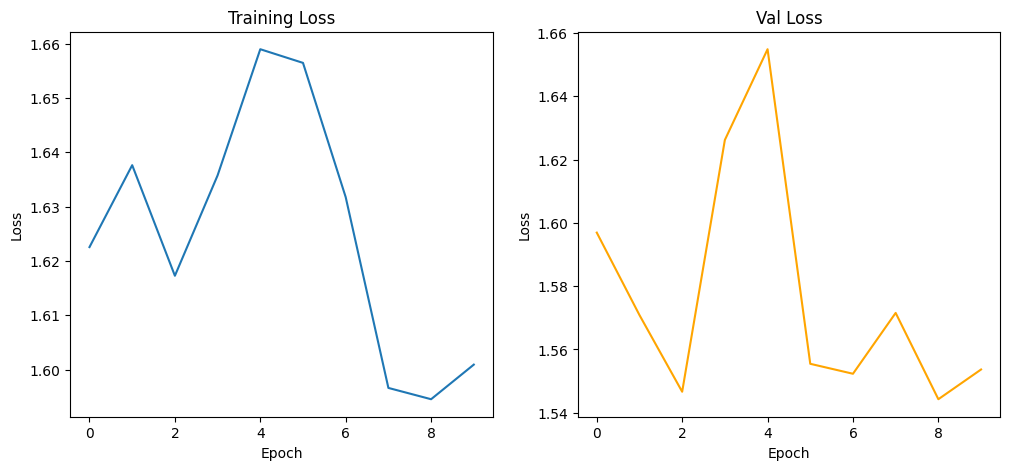

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## 7. Evaluation

In [28]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.358974358974359
Test accuracy:  0.36923076923076925


## Predict

In [29]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.3 MB/s eta 0:00:00


In [30]:
import io
import ipywidgets as widgets
from IPython.display import display, clear_output
from torchvision import transforms
from PIL import Image
import torch
import spacy

# Load your Spacy model for tokenization
eng = spacy.load("en_core_web_sm")

# Assume 'model', 'vocab', 'idx_to_classes' are already defined and loaded
# Make sure to move your model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def preprocess_image(image_bytes, transform):
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    image = image.to(device)
    return image

def preprocess_question(question, vocab, max_seq_len=20):
    tokens = [token.text for token in eng.tokenizer(question)]
    sequence = []
    for token in tokens:
        # Attempt to get the index of the token from vocab
        # Fallback to a predefined index for unknown tokens if the token is not found
        token_index = vocab[token] if token in vocab else vocab['<unk>']
        sequence.append(token_index)
    if len(sequence) < max_seq_len:
        sequence += [vocab['<pad>']] * (max_seq_len - len(sequence))
    else:
        sequence = sequence[:max_seq_len]
    question_tensor = torch.tensor(sequence).unsqueeze(0)  # Add batch dimension
    question_tensor = question_tensor.to(device)
    return question_tensor

def predict_answer(model, image_bytes, question, transform, vocab, idx_to_classes, device):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        image = preprocess_image(image_bytes, transform)
        question_tensor = preprocess_question(question, vocab)

        output = model(image, question_tensor)
        prediction = output.argmax(dim=1).item()

        answer = idx_to_classes[prediction]
        return answer

# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Widgets setup
uploader = widgets.FileUpload(accept='image/*', multiple=False)
question_input = widgets.Text(placeholder='Type your question here', description='Question:', disabled=False)
predict_button = widgets.Button(description="Predict")
clear_button = widgets.Button(description="Clear Image")
output_area = widgets.Output()

def on_predict_button_clicked(b):
    with output_area:
        clear_output()
        if not uploader.value:
            print("No image uploaded!")
            return
        if not question_input.value.strip():
            print("Please enter a question.")
            return

        # Display the uploaded image
        image_info = next(iter(uploader.value.values()))
        image_bytes = image_info['content']
        image = Image.open(io.BytesIO(image_bytes))
        display(image.resize((224, 224)))  # Resize for display purposes

        # Predict the answer
        question = question_input.value
        answer = predict_answer(model, image_bytes, question, transform, vocab, idx_to_classes, device)

        # Display the answer
        print(f"Answer: {answer}")

def on_clear_button_clicked(b):
    # Clear the uploader widget and any displayed output
    uploader.value.clear()
    uploader._counter = 0
    with output_area:
        clear_output()
        print("Image cleared. Upload a new image.")

predict_button.on_click(on_predict_button_clicked)
clear_button.on_click(on_clear_button_clicked)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [31]:
def display_result (uploader, question_input, predict_button, clear_button, output_area):
  # Display widgets
  display(uploader, question_input, predict_button, clear_button, output_area)

In [32]:
display_result (uploader, question_input, predict_button, clear_button, output_area)

FileUpload(value={}, accept='image/*', description='Upload')

Text(value='', description='Question:', placeholder='Type your question here')

Button(description='Predict', style=ButtonStyle())

Button(description='Clear Image', style=ButtonStyle())

Output()